### Imputing Missing Ratings

In [1]:
import pandas as pd

df = pd.read_csv("data.csv")
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df.head()

,User,Game,Rating
0,dumedum,The Legend of Zelda: Breath of the Wild,10
1,dumedum,Tom Clancy's Ghost Recon: Shadow Wars 3D,10
2,dumedum,Darkman,10
3,Action51,Pokémon Sun and Moon,9
4,Action51,Twisted Fusion,7


In [3]:
#Dataframe with only rated items
df_full = df[df["Rating"] != "No Score"]

In [4]:
#Converting to numeric data type
df_full["Rating"] = pd.to_numeric(df_full["Rating"])

In [5]:
#Finding users' average ratings
import numpy as np 

user_pivot = pd.pivot_table(df_full, values='Rating', index=['User'],
                aggfunc=(np.mean, 'count', np.median))

In [6]:
#Getting overall mean
ovr_mean = df_full["Rating"].mean()
print(ovr_mean)

7.893353846153846


In [7]:
#Getting overall median
ovr_median = df_full["Rating"].median()
print(ovr_median)

8.0


In [8]:
#Imputing No Score cells with either the user median or the global median rating

ovr_median = df_full["Rating"].median()

for index, row in df.iterrows():
    if row["Rating"] == "No Score":
        if user_pivot.index.contains(row["User"]):
            row["Rating"] = round(user_pivot.loc[row["User"]]["median"], 0)
        else:
            row["Rating"] = ovr_median

In [9]:
df["Rating"] = df["Rating"].astype(int)

In [169]:
def fill_no_score(df, rating_column, user_column):
    #Creating full dataframe
    df_full = df[df[rating_column] != "No Score"]
    df_full[rating_column] = pd.to_numeric(df_full[rating_column])
    
    #Creating pivot by user
    user_pivot = pd.pivot_table(df_full, values=rating_column, index=[user_column],
                                aggfunc=(np.mean, 'count', np.median))
    
    #Find overall median
    ovr_median = df_full[rating_column].median()
    
    #Impute no score values with either user median or global median
    for index, row in df.iterrows():
        if row[rating_column] == "No Score":
            if user_pivot.index.contains(row[user_column]):
                row[rating_column] = round(user_pivot.loc[row[user_column]]["median"], 0)
            else:
                row["Rating"] = ovr_median
    return df

In [168]:
df_check = pd.read_csv("data.csv")
print(df_check.head())
print(len(df_check[df_check["Rating"] == "No Score"]))

       User                                      Game Rating
0   dumedum   The Legend of Zelda: Breath of the Wild     10
1   dumedum  Tom Clancy's Ghost Recon: Shadow Wars 3D     10
2   dumedum                                   Darkman     10
3  Action51                      Pokémon Sun and Moon      9
4  Action51                            Twisted Fusion      7
11305


In [170]:
df_check_new = fill_no_score(df_check, "Rating", "User")

In [174]:
df_check_new["Rating"] = df_check_new["Rating"].astype(int)

In [175]:
def plt_ratings(df, rating_column):
    #Function for plotting rating histogram
    plt.xlabel('Rating Value')
    plt.ylabel('Count of Ratings')
    plt.title('Histogram of Ratings Distribution')
    plt.grid(True)
    plt.hist(df[rating_column], alpha=0.75, bins=10, edgecolor='black')
    plt.show()

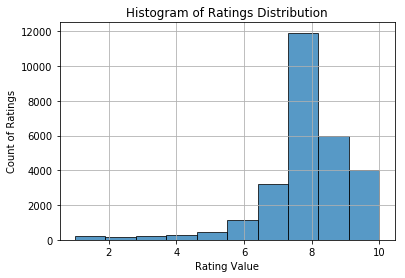

In [176]:
plt_ratings(df_check_new, "Rating")

In [ ]:
#Histogram of game distribution
plt.figure(figsize=(12,10))
plt.xlabel('Count of Game Ratings')
plt.ylabel('Count of Games')
plt.title('Histogram of Game Distribution')
plt.grid(True)
plt.hist(df.groupby("Game")["Rating"].count(), bins=30, log=True, alpha=0.75, edgecolor='black')

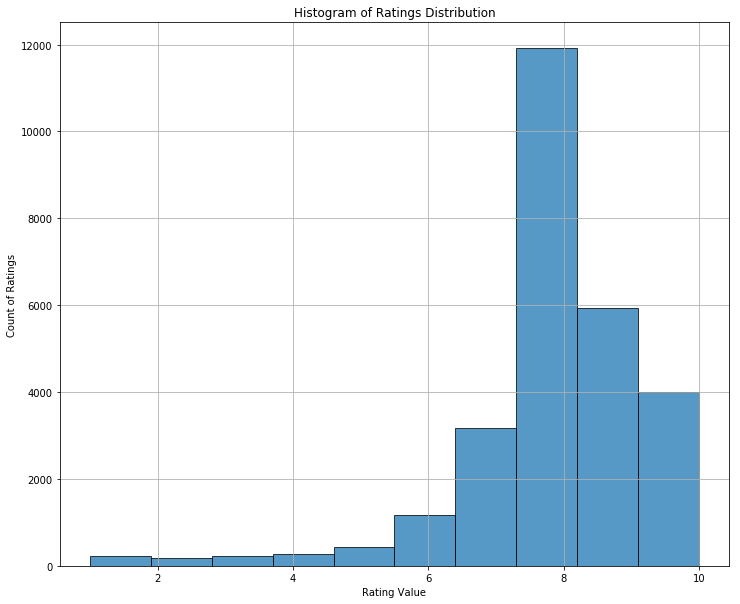

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.xlabel('Rating Value')
plt.ylabel('Count of Ratings')
plt.title('Histogram of Ratings Distribution')
plt.grid(True)
plt.hist(df["Rating"], alpha=0.75, bins=10, edgecolor='black')
plt.show()

### Continuing with SVD++
- Understanding the different hyper parameters, understanding some of the source code
- Hyper-parameter tuning

In [12]:
#Importing surprise modules
#Importing surprise modules
from surprise import Reader, accuracy, Dataset
from surprise.model_selection import KFold, cross_validate, train_test_split
from surprise import SVD, SVDpp

In [179]:
def create_surprise_dataset(df, user_col, item_col, rating_col, rating_scale):
    reader = Reader(rating_scale=rating_scale)
    surprise_data = Dataset.load_from_df(df[[user_col, item_col, rating_col]], reader)
    return surprise_data

In [180]:
ng_data = create_surprise_dataset(df_check_new, "User", "Game", "Rating", (1, 10))

In [181]:
ng_data

In [13]:
#Instantiating reader and dataset object
reader = Reader(rating_scale=(1, 10))
game_data = Dataset.load_from_df(df[[user_col, item_col, rating_col]], reader)

In [14]:
trainset, testset = train_test_split(game_data, test_size=0.25)

### Simulating SVD++ Code

In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numbers

import numpy as np


def get_rng(random_state):
    '''Return a 'validated' RNG.

    If random_state is None, use RandomState singleton from numpy.  Else if
    it's an integer, consider it's a seed and initialized an rng with that
    seed. If it's already an rng, return it.
    '''
    if random_state is None:
        return np.random.mtrand._rand
    elif isinstance(random_state, (numbers.Integral, np.integer)):
        return np.random.RandomState(random_state)
    if isinstance(random_state, np.random.RandomState):
        return random_state
    raise ValueError('Wrong random state. Expecting None, an int or a numpy '
                     'RandomState instance, got a '
                     '{}'.format(type(random_state)))

In [ ]:
#Running SVD++ with params

#Setting initial baselines to 0
bu = np.zeros(trainset.n_users, np.double)
bi = np.zeros(trainset.n_items, np.double)

In [ ]:
rng = get_rng(33)

In [ ]:
#Initializing parameters according to suprise's defaults
init_mean = 0
init_std_dev = .1
n_factors = 20

#Initializing user factors, randomly initialized according to a normal distribution
pu = rng.normal(init_mean, init_std_dev,
                (trainset.n_users, n_factors))

#Initializing item factors, randomly initialized according to a normal distribution

qi = rng.normal(init_mean, init_std_dev,
                (trainset.n_items, n_factors))

#Initializing new item factors, initialized the same way as qi
yj = rng.normal(init_mean, init_std_dev,
                (trainset.n_items, n_factors))

#Initializing implicit feedback matrix
u_impl_fdb = np.zeros(n_factors, np.double)

print(pu.shape)
print(qi.shape)
print(yj.shape)
print(u_impl_fdb.shape)

In [ ]:
#Running the SGD
global_mean = trainset.global_mean
n_epochs = 20
verbose = True
lr_bu = .007
lr_bi = .007
lr_pu = .007
lr_qi = .007
lr_yj = .007
reg_bi = .02
reg_bu = .02
reg_yj = .02
reg_pu = .02
reg_qi = .02

for current_epoch in range(n_epochs):
    if verbose:
        print(" processing epoch {}".format(current_epoch))
    #For user, item, rating in the trainset
    for u, i, r in trainset.all_ratings():
        
        # items rated by u. This is COSTLY
        #Iu creates a list of items rated by user u
        Iu = [j for (j, _) in trainset.ur[u]]
        #sqrt_Iu is just the square root of the size of Iu. Used to discount implicit feedback 
        sqrt_Iu = np.sqrt(len(Iu))
        
        #compute implicit feedback
        u_impl_fdb = np.zeros(n_factors, np.double)
        #for each item that was rated in Iu
        for j in Iu:
            #for each factor
            for f in range(n_factors):
                #Update the implicit feedback factor by dividing that item, factor value
                #by the sqrt of Iu for that item
                u_impl_fdb[f] += yj[j, f] / sqrt_Iu
        
        #compute current error
        dot = 0 # <q_i, (p_u + sum_{j in Iu} y_j / sqrt{Iu}>
        #for each factor
        for f in range(n_factors):
            #Add the value implicit feedback for that factor with the user feedback factor
            #and Multiply that value by the item factor
            dot += qi[i, f] * (pu[u, f] + u_impl_fdb[f])
            #Calculate current error by taking the labeled rating r and subtracting the 
            #sum of the global mean, the user baseline, the item baseline and the dot product of the factors
            #which we calculated above
            err = r - (global_mean + bu[u] + bi[i] + dot)
        
        # update biases aka baselines
        #Updating user baselines by multiplying the current baseline by the user baseline regularization term, 
        #subtracting that from the error, and multiplying that result by the user baseline learning rate and
        #adding to the current user baseline
        bu[u] += lr_bu * (err - reg_bu * bu[u])
        #Updating item baselines by multiplying the current baseline by the item baseline regularization term, 
        #subtracting that from the error, and multiplying that result by the item baseline learning rate and
        #adding to the current user baseline
        bi[i] += lr_bi * (err - reg_bi * bi[i])
        
        # update factors
        for f in range(n_factors):
            #user factor at that factor
            puf = pu[u, f]
            #item factor at that factor
            qif = qi[i, f]
            #update user factor taking error by item factor and regularizing by user factor, current item factor
            # and multiplying all by learning rate
            pu[u, f] += lr_pu * (err * qif - reg_pu * puf)
            #update item factor by taking error, multiplying by user factor, implicit feedback for item at that factor
            #regularization term and regularizing item factor, multiplying all by learning rate
            qi[i, f] += lr_qi * (err * (puf + u_impl_fdb[f]) -
                                 reg_qi * qif)
            #For each item in the Iu matrix
            #update the implicit feedback matrix by multiplying error by item factor, dividing by sqrt of Iu
            #subtracting product of regularization term for implicit matrix by implicit rating
            #multiplying all by learning rate Adding to implicit matrix
            for j in Iu:
                yj[j, f] += lr_yj * (err * qif / sqrt_Iu -
                                     reg_yj * yj[j, f])
        #After each epoch, we're left with
        #bu, bi, pu, qi, yj
        

In [ ]:
bu

In [ ]:
bi

In [ ]:
pu

In [ ]:
yj

In [ ]:
qi

### Model Tuning

In [18]:
algo = SVDpp()
cv_svdpp = cross_validate(algo, game_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0846  1.1638  1.0865  1.1321  1.1445  1.1223  0.0316  
MAE (testset)     0.6821  0.7199  0.6860  0.6981  0.7034  0.6979  0.0134  
Fit time          44.17   61.96   59.38   62.06   66.67   58.85   7.70    
Test time         0.70    0.79    0.74    0.95    0.83    0.80    0.09    


In [19]:
cv_svdpp["test_rmse"]

array([1.08462113, 1.16377291, 1.08654775, 1.13209046, 1.14447466])

In [20]:
cv_svdpp["test_rmse"].mean()

1.1223013838796025

In [15]:
algo = SVD()
cv_svd = cross_validate(algo, game_data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1094  1.1539  1.1118  1.1243  1.1264  1.1252  0.0159  
MAE (testset)     0.7026  0.7238  0.7082  0.7131  0.7106  0.7117  0.0070  
Fit time          1.18    1.16    1.16    1.15    1.17    1.16    0.01    
Test time         0.03    0.03    0.03    0.03    0.03    0.03    0.00    


In [16]:
cv_svd["test_rmse"]

array([1.10935798, 1.15392785, 1.11178142, 1.1243371 , 1.12639951])

In [17]:
cv_svd["test_rmse"].mean()

1.1251607747758503

SVDpp is slightly better, so I'll start off by tuning that one.

In [254]:
import time
start_time = time.time()

algo = SVDpp()
cv_svdpp = cross_validate(algo, game_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1137  1.1302  1.1372  1.1271  0.0099  
MAE (testset)     0.6960  0.7117  0.7091  0.7056  0.0069  
Fit time          35.01   39.55   38.94   37.83   2.01    
Test time         1.13    1.11    1.30    1.18    0.09    
--- 117.21870279312134 seconds ---


In [257]:
from surprise.model_selection import GridSearchCV
start_time = time.time()

param_grid = {"n_factors": [20, 30], "n_epochs": [20, 30],
              "lr_all": [0.005, 0.01], "reg_all": [0.05, 0.1]}

gs = GridSearchCV(SVDpp, param_grid, measures=["rmse"], cv=3)

gs.fit(game_data)

print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [256]:
start_time = time.time()

algo = SVD()
cv_svd = cross_validate(algo, game_data, measures=["RMSE", "MAE"], cv=3, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1208  1.1413  1.1343  1.1321  0.0085  
MAE (testset)     0.7195  0.7220  0.7107  0.7174  0.0049  
Fit time          1.22    1.28    1.26    1.26    0.02    
Test time         0.06    0.06    0.07    0.06    0.00    
--- 4.1991190910339355 seconds ---


In [258]:
from surprise.model_selection import GridSearchCV
import time 
start_time = time.time()

param_grid = {"n_factors": [20, 50, 100, 150], "n_epochs": [20, 30, 50],
              "lr_all": [0.002, 0.005, 0.007, 0.01], "reg_all": [0.02, 0.05, 0.1]}

gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)

gs.fit(game_data)

print("--- %s seconds ---" % (time.time() - start_time))

--- 695.1328959465027 seconds ---


In [259]:
gs_results = pd.DataFrame(gs.cv_results)

The hyperparameter tuning really doesn't do much to improve the performance of the RMSE of the model.

In [260]:
params = gs.best_params['rmse']
print(params)

{'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.02}


In [23]:
svdtuned = SVD(n_factors = 20, n_epochs=20, lr_all = 0.007, reg_all= 0.02)

cv_svd_tuned = cross_validate(svdtuned, game_data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0739  1.1118  1.1684  1.1434  1.1106  1.1216  0.0321  
MAE (testset)     0.6947  0.7078  0.7297  0.7154  0.7004  0.7096  0.0122  
Fit time          0.54    0.81    0.59    0.56    0.49    0.60    0.11    
Test time         0.03    0.06    0.03    0.03    0.03    0.04    0.01    


In [182]:
trainset, testset = train_test_split(ng_data, test_size=0.25, random_state=33)

In [183]:
def run_svd(trainset, testset):
    algo = SVD()
    svd_fit = algo.fit(trainset)
    predictions = svd_fit.test(testset)
    return predictions

In [184]:
preds = run_svd(trainset, testset)

[Prediction(uid='JoeDiddley', iid='Namco Museum', r_ui=8.0, est=8.111350862812884, details={'was_impossible': False}), Prediction(uid='Zuljaras', iid='Metroid Fusion', r_ui=10.0, est=9.742287664397901, details={'was_impossible': False}), Prediction(uid='Hawkstream', iid='Mario Kart 8 Deluxe', r_ui=10.0, est=8.74642658147115, details={'was_impossible': False}), Prediction(uid='Ghost-Piece', iid='Super Mario Odyssey', r_ui=1.0, est=5.026202509123143, details={'was_impossible': False}), Prediction(uid='Ryu_Niiyama', iid='Phoenix Wright: Ace Attorney Trials and Tribulations', r_ui=9.0, est=9.529067333934691, details={'was_impossible': False}), Prediction(uid='OneBagTravel', iid='Chrono Trigger', r_ui=10.0, est=9.345613497059848, details={'was_impossible': False}), Prediction(uid='Undead_terror', iid='Metroid II: Return of Samus', r_ui=8.0, est=7.956376531341287, details={'was_impossible': False}), Prediction(uid='FGPackers', iid='Star Fox Guard', r_ui=8.0, est=7.93408012935632, details={'w

### New Evaluation Metrics

I want to start off by checking some of the recommended items for a few different users against their actual items in the test set. Then, I can potentially start trying to check the algos in terms of MAP@K and potentially the "hit rate".

In [24]:
trainset, testset = train_test_split(game_data, test_size=0.25, random_state=33)

In [26]:
algo = SVD(n_factors = 20, n_epochs=20, lr_all = 0.007, reg_all= 0.02)

svd_fit = algo.fit(trainset)

predictions = svd_fit.test(testset)

print(accuracy.rmse(predictions))

RMSE: 1.1311
1.1311123822663154


In [30]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [28]:
top_n_predictions = get_top_n(predictions, n=10)

In exploring the prediction object, it looks like it outputs a prediction for each r_ui in the test set. The output provides an outer user id, an outer item id. I want to compare the list of predictions for a few users with their actual items in the test set.

In [31]:
def create_testset_dict(testset):
    '''
    Return the items rated by a given user within the testset, sorted in descending order.
    
    :params: testset: A testset generated via Surprise
    : returns testset_dict: a collection of users, items which they rated and the given rating
    '''
    testset_dict = defaultdict(list)
    
    for row in testset:
        uid, iid, gt_rating = row
        testset_dict[uid].append((iid, gt_rating))
        
    for uid, user_ratings in testset_dict.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        testset_dict[uid] = user_ratings
        
    return testset_dict

In [32]:
testset_dict = defaultdict(list)

for row in testset:
    uid, iid, gt_rating = row
    testset_dict[uid].append((iid, gt_rating))
    
#Sorting testset_dict for top 10 items by user
for uid, user_ratings in testset_dict.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        testset_dict[uid] = user_ratings

In [33]:
#Testing for user Joe Diddley
joe_diddley_testset = testset_dict["JoeDiddley"]
joe_diddley_items = [item for item, rating in joe_diddley_testset]
print(joe_diddley_items)
    
joe_diddley_recs = top_n_predictions["JoeDiddley"]
joe_diddley_top10_recs = [item for item, rating in joe_diddley_recs]
print(joe_diddley_top10_recs)

['The Legend of Zelda: Breath of the Wild', 'The Legend of Zelda: A Link Between Worlds', 'SteamWorld Heist: Ultimate Edition', 'Shin Megami Tensei IV: Apocalypse', 'Super Mario Galaxy 2', "Super Mario World 2: Yoshi's Island", 'Wargroove', 'Namco Museum', 'Mario Power Tennis', 'Mario + Rabbids Kingdom Battle', 'Mario Kart Wii', 'Rayman Legends: Definitive Edition', "Mario's Picross", 'Fire Emblem Fates', 'Metal Slug 3', 'Picross 3D Round 2', 'Star Fox 64 3D', 'Downwell', 'Disgaea 1 Complete', 'MadWorld', 'Cave Story+', 'New Play Control! Pikmin 2', 'Radiant Historia: Perfect Chronology', 'Rayman Origins', 'SEGA Mega Drive Classics', 'Fire Emblem Echoes: Shadows of Valentia', 'Donkey Kong', '3D Out Run', 'Boom Blox Bash Party', 'Mario Kart Super Circuit', 'Maestro! Green Groove', 'Worms W.M.D.', 'New Super Mario Bros. Wii', 'F-Zero Maximum Velocity', 'Picross S', "Yoshi's Story"]
['Super Mario Galaxy 2', 'The Legend of Zelda: Breath of the Wild', 'The Legend of Zelda: A Link Between Wo

In [77]:
#Testing for user Megal0maniac
Megal0maniac_testset = testset_dict["Megal0maniac"]
Megal0maniac_items = [item for item, rating in Megal0maniac_testset]
    
Megal0maniac_recs = top_n_predictions["Megal0maniac"]
Megal0maniac_top10_recs = [item for item, rating in Megal0maniac_recs]

print(Megal0maniac_items)
print(Megal0maniac_top10_recs)

['Super Mario Maker', 'Mega Man Legacy Collection', "Yoshi's Woolly World", 'Neo Turf Masters', 'Mario Kart 7', 'Super Mario Odyssey', "Kirby's Star Stacker", 'Pushmo World', 'Castlevania: Dawn of Sorrow', 'Wario Land: Super Mario Land 3', "Shantae And The Pirate's Curse", 'Magician Lord', 'Celeste', 'Inazuma Eleven', 'Mario vs. Donkey Kong: Tipping Stars', 'Chess Ultra', 'Star Fox 2', 'Metroid Prime: Hunters', "Donkey Kong Country 3: Dixie Kong's Double Trouble!", 'Paper Mario: Sticker Star', 'Fire Emblem Fates', 'Ghost Trick: Phantom Detective', 'Mario + Rabbids Kingdom Battle: Donkey Kong Adventure', 'Mario Kart 8 Deluxe', 'Enter the Gungeon', 'Super Mario Galaxy', 'Shock Troopers', 'The Legend of Zelda: Twilight Princess HD', 'Metroid Prime 3: Corruption', 'Mario & Luigi: Paper Jam', 'Sonic Mania', 'Fire Emblem: Awakening', 'Mario & Luigi: Superstar Saga', 'Into The Breach', 'Phoenix Wright: Ace Attorney', "Donkey Kong Country 2: Diddy's Kong Quest", 'Contra 4', "Capcom Beat 'Em Up

We only got 1/10 correct for Megal0maniac - not as good. But, the recommendations are generally popular, well known games, with some decent relation to the games that he likes, so I wouldn't necessarily call them bad recommendations.<br>
Let's try it with one more user for good measure - Octane.

In [36]:
#Testing for user Octane
Octane_testset = testset_dict["Octane"]
Octane_items = [item for item, rating in Octane_testset]
    
Octane_recs = top_n_predictions["Octane"]
Octane_top10_recs = [item for item, rating in Octane_recs]

print(Octane_items)
print(Octane_top10_recs)

['Mario Kart 8', 'Splatoon', 'Super Mario Galaxy', 'The Legend of Zelda: The Wind Waker HD', 'Pikmin 3', 'Super Mario 64', 'Donkey Kong Jungle Beat', 'Super Mario Odyssey', 'Animal Crossing', "The Legend of Zelda: Majora's Mask", "Kirby's Epic Yarn", 'Captain Toad: Treasure Tracker', 'Monster Hunter 3 (Tri~)', 'MadWorld', 'F-Zero GX', 'Bayonetta', 'Pikmin', 'Xenoblade Chronicles', 'Mario Kart: Double Dash!!', "Zack & Wiki: Quest for Barbaros' Treasure", "Kirby's Return to Dream Land", 'Pokkén Tournament', 'The Legend of Zelda: Skyward Sword', 'Opoona', 'Star Fox Zero']
['Super Mario Odyssey', 'Xenoblade Chronicles', 'Mario Kart: Double Dash!!', 'The Legend of Zelda: The Wind Waker HD', 'Bayonetta', 'Mario Kart 8', 'Super Mario Galaxy', 'Super Mario 64', 'Pikmin', 'Splatoon']


We actually got 6/10 for Octane - so from the looks of this small sample size, our recommender doesn't do a bad job at recommending games off the bat. <br>
From here, I want to give a try at looking at some of the evaluation metrics specified here: https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093

In [37]:
import recmetrics

In [38]:
#Assigning an ID to the games to be used with recmetrics
df = df.assign(item_id=(df['Game']).astype('category').cat.codes)

In [40]:
df[df["Game"] == "The Legend of Zelda: Breath of the Wild"]

,User,Game,Rating,item_id
0,dumedum,The Legend of Zelda: Breath of the Wild,10,3780
105,Coach_A,The Legend of Zelda: Breath of the Wild,10,3780
106,Coach_A,The Legend of Zelda: Breath of the Wild,10,3780
113,mowerdude,The Legend of Zelda: Breath of the Wild,9,3780
114,mowerdude,The Legend of Zelda: Breath of the Wild,9,3780
202,FlashBoomerang,The Legend of Zelda: Breath of the Wild,10,3780
268,mist,The Legend of Zelda: Breath of the Wild,10,3780
307,GeoChrome,The Legend of Zelda: Breath of the Wild,10,3780
589,Slim_Boy_Fat,The Legend of Zelda: Breath of the Wild,10,3780
598,FX102A,The Legend of Zelda: Breath of the Wild,8,3780


In [41]:
df["Game"].nunique()

4328

In [129]:
4328 * .2

865.6

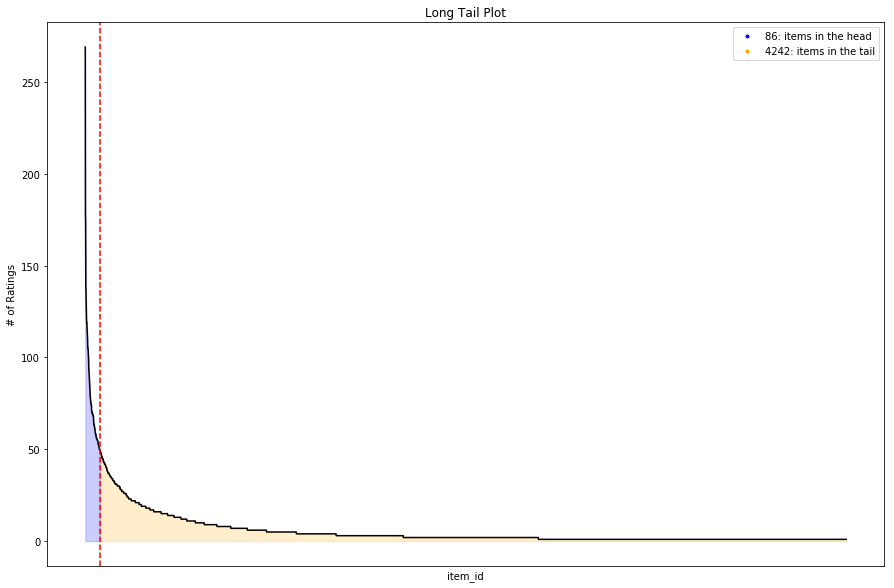

In [42]:
plt.figure(figsize=(15,10))
recmetrics.long_tail_plot(df, "item_id", "Ratings", .25, False)

Our data has a very long tail clearly, with the majority of ratings taking place for the top 100 items or so.

In [142]:
#AP@K
import ml_metrics

Help on package ml_metrics:

NAME
    ml_metrics

PACKAGE CONTENTS
    auc
    average_precision
    custom (package)
    edit_distance
    elementwise
    quadratic_weighted_kappa

FILE
    /Users/josephberkowitz/anaconda3/lib/python3.7/site-packages/ml_metrics/__init__.py




In [43]:
#checking average precision@10 for our three users above
from ml_metrics import average_precision

jd_apk = average_precision.apk(joe_diddley_items, joe_diddley_top10_recs)
mg_apk = average_precision.apk(Megal0maniac_items, Megal0maniac_top10_recs)
oc_apk = average_precision.apk(Octane_items, Octane_top10_recs)

print("Avg Precision @ 10 for Joe_Diddley: ", jd_apk)
print("Avg Precision @ 10 for Megal0maniac ", mg_apk)
print("Avg Precision @ 10 for Octane ", oc_apk)

Avg Precision @ 10 for Joe_Diddley:  1.0
Avg Precision @ 10 for Megal0maniac  1.0
Avg Precision @ 10 for Octane  1.0


I want to try to get mean average precision @ 10 for the entire set.

I need to order the two collections by username alphabetically and make sure that the two lists of lists are appearing in the correct order when we evaluate MAP@K.

In [185]:
ordered_testset_users = sorted(testset_dict)
print(len(ordered_testset_users))

410


In [186]:
ordered_prediction_users = sorted(top_n_predictions)
print(len(ordered_prediction_users))

410


In [187]:
for user in ordered_prediction_users:
    user_predicted_item_list = []

1UP_MARIO
3dg3d3m0n
6ch6ris6
96OopAmgems
Aaron09
Action51
Agriculture
Akuza89
Alantor28
Alber-san
AlliMeadow
AndreaF96
Anti-Matter
Anvold
Aozz101x
Arbor
Arcadtic
Arcamenel
Archer-bro
Arminillo
Arpie
Atomic77
BAN
BeanoMaster
BenGrimm
Bentleyma
Berserker26
Bevinator
Bezbot
BlackTalon2
Blathers
BlueBlur101
BlueKnight07
BlueOcean
Blue_Blur
Bluefiregamer
Bolt_Strike
BongoBongo123
BraveSonic
BruceCM
Buizel
Bunkerneath
CaPPa
Captain_Toad
CargoSushiimira
CaterpillarGuy59
CaviarMeths
CharlieGirl
Chimaj
Churchy
Cissero
Coach_A
Cotillion
CroRock
Cynas
DBPirate
DFaceG_Rebooted
Daftbomb
Daloblast
Danpal65
Dark-Luigi
DarkRula
Darknyht
DefHalan
Deku-Scrub
DenDen
Desa
Dezzy
Diddy64
Dilly_D_Williams
Dizzy_Boy
DockEllisD
DoctorOverbuild
Doger
Dogorilla
Dpullam
DrkBndr
DuskformLycanroc
DylanMcGrann
Eagle9
Eel
EgillPT
EightyTwoStu
Emperor-Palpsy
Eric258
EvilLucario
ExtremelyTired
F1R3F1Y
FGPackers
FX102A
FaeKnight
Fandabidozi
Farmboy74
Filth_Element
Fingeldor
FlashBoomerang
Flukey73
FragRed
FriedSquid
Gam

In [188]:
full_item_list = []
full_predicted_item_list = []
for user in ordered_prediction_users:
    user_item_list = []
    user_predicted_item_list = []
    if user in ordered_testset_users:
        for ir in testset_dict[user]:
            item, rating = ir
            user_item_list.append(item)
        for ir in top_n_predictions[user]:
            item, rating = ir
            user_predicted_item_list.append(item)
        full_item_list.append(user_item_list)
        full_predicted_item_list.append(user_predicted_item_list)

In [191]:
def get_ordered_items_and_predictions(testset, predictions):
    #Sort prediction and testset alphabetically
    ordered_predictions = sorted(predictions)
    ordered_testset = sorted(testset)
    #Instantiate lists
    full_item_list = []
    full_predicted_item_list = []
    #for each user in the prediction users
    for user in ordered_prediction_users:
        user_item_list = []
        user_predicted_item_list = []
        #if the user is in the testset
        if user in ordered_testset_users:
            #add the item to the user_item list
            for ir in testset_dict[user]:
                item, rating = ir
                user_item_list.append(item)
            #add the item to the prediction user list
            for ir in top_n_predictions[user]:
                item, rating = ir
                user_predicted_item_list.append(item)
            #add the list to the full list
            full_item_list.append(user_item_list)
            full_predicted_item_list.append(user_predicted_item_list)
            
    return full_item_list, full_predicted_item_list

In [192]:
items, preds = get_ordered_items_and_predictions(testset_dict, top_n_predictions)

[['Swords & Soldiers II', 'Brain Age: Concentration Training', "Yoshi's Woolly World", 'Thumper', 'New Super Mario Bros. 2', 'Super Mario 64 DS', 'Donkey Kong Country: Tropical Freeze', 'Runbow'], ['Defense Grid 2', 'Donkey Kong Country: Tropical Freeze', 'Wolfenstein II: The New Colossus', 'Dark Souls: Remastered', 'SteamWorld Dig 2'], ['Wave Race', 'Super Mario Land'], ['Mario Kart 8', 'Pokémon X & Y', 'Super Mario 3D Land', 'Monster Hunter 3 Ultimate', 'Pokémon Black and White', 'The Legend of Zelda: Skyward Sword', 'The Legend of Zelda: Twilight Princess HD', 'Hyrule Warriors', 'Shin Megami Tensei IV', 'Pokémon Rumble'], ['The Legend of Zelda: Breath of the Wild', 'Super Mario 3D World', 'Xenoblade Chronicles', 'Splatoon 2', 'Animal Crossing: New Leaf', 'Bravely Second: End Layer', 'Bravely Default', 'The Legend of Zelda: The Wind Waker HD', 'Metroid: Samus Returns', 'Little Nightmares: Complete Edition', 'Tokyo Mirage Sessions #FE', 'ARMS', 'DOOM', 'Mario & Luigi: Dream Team', "Yo

In [189]:
mean_apk = average_precision.mapk(actual=full_item_list, predicted=full_predicted_item_list)

In [190]:
mean_apk

0.9980049776007964

Our mean average precision @ 10 is 0.771 - actually pretty good, at least I think.

Average precision @ K: The number of relevant items recommended @ K / The number of recommended items
Let's check out average recall @ K, which predicts the, number of relevant recommended items / total relevant items.
I think, and what I'm guessing is that there needs to be a cutoff for Mean average recall, whereas there doesn't for precision. 

In [53]:
mean_ark = recmetrics.mark(actual=full_item_list, predicted=full_predicted_item_list, k=10)

In [54]:
mean_ark

0.7680093692388908

Let's check out the coverage for our model, which is the percent of items that the recommender is able to recommend.

coverage = I/N * 100

Where 'I' is the number of unique items the model recommends in the test data, and 'N' is the total number of unique items in the training data.

In [55]:
all_trainset_items = [trainset.to_raw_iid(item_id) for item_id in trainset.all_items()]
print(all_trainset_items)

['Pokémon Trading Card Game', 'Super Mario Maker', 'The Legend of Zelda: The Wind Waker HD', 'The Legend of Zelda: The Wind Waker', 'Tiny Barbarian DX', 'YouTube', 'Shin Megami Tensei IV: Apocalypse', 'Stealth Inc 2: A Game of Clones', 'Professor Layton and the Miracle Mask', 'Fire Emblem: Three Houses', 'The Legend of Zelda: Ocarina of Time / Master Quest', 'Punch-Out!! Featuring Mr. Dream', 'Pokémon Omega Ruby and Alpha Sapphire', 'The Banner Saga', 'Mario Kart DS', "Assassin's Creed IV Black Flag", 'Inside', "Luigi's Mansion 3", 'ZombiU', 'Pokémon Platinum', 'Kirby: Nightmare in Dream Land', 'Punch-Out!!', 'Super Mario All-Stars', 'Splatoon 2', 'Kid Tripp', 'Golden Sun: Dark Dawn', 'Need for Speed: Underground', 'Balloon Fight', 'Shin Megami Tensei: Devil Summoner: Soul Hackers', 'Blaster Master Zero', 'Professor Layton and the Curious Village', 'New Super Mario Bros. Wii', 'Dr. Mario', 'Chrono Trigger', 'Dark Souls: Remastered', "Kirby's Adventure", 'Family Tennis SP', 'Minecraft: 

In [97]:
full_predicted_item_list

[['Donkey Kong Country: Tropical Freeze',
  'Runbow',
  'Thumper',
  'Swords & Soldiers II',
  'Super Mario 64 DS',
  "Yoshi's Woolly World",
  'Brain Age: Concentration Training',
  'New Super Mario Bros. 2'],
 ['Donkey Kong Country: Tropical Freeze',
  'Wolfenstein II: The New Colossus',
  'SteamWorld Dig 2',
  'Dark Souls: Remastered',
  'Defense Grid 2'],
 ['Super Mario Land', 'Wave Race'],
 ['Mario Kart 8',
  'Shin Megami Tensei IV',
  'The Legend of Zelda: Twilight Princess HD',
  'Super Mario 3D Land',
  'The Legend of Zelda: Skyward Sword',
  'Pokémon Rumble',
  'Pokémon Black and White',
  'Pokémon X & Y',
  'Hyrule Warriors',
  'Monster Hunter 3 Ultimate'],
 ['The Legend of Zelda: Breath of the Wild',
  'Xenoblade Chronicles',
  'The Legend of Zelda: The Wind Waker HD',
  'Splatoon 2',
  'Animal Crossing: New Leaf',
  'Super Mario 3D World',
  "Yoshi's Woolly World",
  'Metroid: Samus Returns',
  'Bravely Default',
  'Tokyo Mirage Sessions #FE'],
 ['Bayonetta 2',
  'Xenoblade

In [57]:
coverage = recmetrics.coverage(predicted=full_predicted_item_list, catalog=all_trainset_items)

In [58]:
coverage

20.31

It looks like we can recommend a little more than 20% of the items in the training set. 

In [59]:
personalization_score = recmetrics.personalization(full_predicted_item_list)
print(personalization_score)

0.9728598242954251


# Source Code for Evaluation Metrics

### AP@K and MAP@K

In [60]:
#average precision @ k
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

In [66]:
#initializes score and n_hits
score = 0.0
num_hits = 0.0
k = 10

#Sets our predicted items vs actual items
predicted = joe_diddley_top10_recs
actual = joe_diddley_items

if len(predicted) > k:
    predicted = predicted[:k]

#enumerate through predicted items
for i, p in enumerate(predicted):
    #if item from predicted in actual and hasn't appeared already in the predi
    if p in actual and p not in predicted[:i]:
        #Increment num_hits by 1 if meets the condition
        num_hits += 1.0
        #Increment score by number of hits at that index plus the index + 1
        score += num_hits / (i + 1.0)
        print(num_hits)
        print(score)
    
if not actual:
    print(0.0)
    
#return the final score divided by either the length of the actual data or k max number of predicted elements
print(score / min(len(actual), k))

1.0
1.0
2.0
2.0
3.0
3.0
4.0
4.0
5.0
5.0
6.0
6.0
7.0
7.0
8.0
8.0
9.0
9.0
10.0
10.0
1.0


In [67]:
#mean average precision @ k

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [81]:
len(actual)

410

In [82]:
actual = full_item_list
predicted = full_predicted_item_list
z = zip(actual, predicted)
k=10
i = 0
for a, p in z:
    print(i, apk(a, p, k))
    i += 1

0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 1.0
17 1.0
18 1.0
19 1.0
20 1.0
21 1.0
22 1.0
23 1.0
24 1.0
25 1.0
26 1.0
27 1.0
28 1.0
29 1.0
30 1.0
31 1.0
32 1.0
33 1.0
34 1.0
35 1.0
36 1.0
37 1.0
38 1.0
39 1.0
40 1.0
41 1.0
42 1.0
43 1.0
44 1.0
45 1.0
46 1.0
47 1.0
48 1.0
49 1.0
50 1.0
51 1.0
52 1.0
53 1.0
54 1.0
55 1.0
56 1.0
57 1.0
58 1.0
59 1.0
60 1.0
61 1.0
62 1.0
63 1.0
64 1.0
65 1.0
66 1.0
67 1.0
68 1.0
69 1.0
70 1.0
71 1.0
72 1.0
73 1.0
74 1.0
75 1.0
76 1.0
77 1.0
78 1.0
79 1.0
80 1.0
81 1.0
82 1.0
83 1.0
84 1.0
85 1.0
86 1.0
87 1.0
88 1.0
89 1.0
90 1.0
91 1.0
92 1.0
93 1.0
94 1.0
95 1.0
96 1.0
97 1.0
98 1.0
99 1.0
100 1.0
101 1.0
102 1.0
103 1.0
104 1.0
105 1.0
106 1.0
107 1.0
108 1.0
109 1.0
110 1.0
111 1.0
112 1.0
113 1.0
114 1.0
115 1.0
116 1.0
117 1.0
118 1.0
119 1.0
120 1.0
121 1.0
122 1.0
123 1.0
124 1.0
125 1.0
126 1.0
127 1.0
128 1.0
129 1.0
130 1.0
131 1.0
132 1.0
133 1.0
134 1.0
135 1.0
136 1.0
137 1.0
138 1.

In [101]:
actual = full_item_list
predicted = full_predicted_item_list
z = zip(actual, predicted)
k=10

for a, p in z:
    print(apk(a, p, k))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.89
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.89
0.7010204081632653
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

In [103]:
np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

0.9980049776007964

### Coverage

In [105]:
#Coverage
help(recmetrics.coverage)

Help on function coverage in module recmetrics.metrics:

coverage(predicted, catalog)
    Computes the coverage for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    Returns
    ----------
    coverage:
        The coverage of the recommendations as a percent
        rounded to 2 decimal places



In [107]:
for sublist in predicted:
    for p in sublist:
        print(p)

Donkey Kong Country: Tropical Freeze
Runbow
Thumper
Swords & Soldiers II
Super Mario 64 DS
Yoshi's Woolly World
Brain Age: Concentration Training
New Super Mario Bros. 2
Donkey Kong Country: Tropical Freeze
Wolfenstein II: The New Colossus
SteamWorld Dig 2
Dark Souls: Remastered
Defense Grid 2
Super Mario Land
Wave Race
Mario Kart 8
Shin Megami Tensei IV
The Legend of Zelda: Twilight Princess HD
Super Mario 3D Land
The Legend of Zelda: Skyward Sword
Pokémon Rumble
Pokémon Black and White
Pokémon X & Y
Hyrule Warriors
Monster Hunter 3 Ultimate
The Legend of Zelda: Breath of the Wild
Xenoblade Chronicles
The Legend of Zelda: The Wind Waker HD
Splatoon 2
Animal Crossing: New Leaf
Super Mario 3D World
Yoshi's Woolly World
Metroid: Samus Returns
Bravely Default
Tokyo Mirage Sessions #FE
Bayonetta 2
Xenoblade Chronicles X
Metroid Prime Trilogy
Super Metroid
Final Fantasy Tactics Advance
Twisted Fusion
Code Name: S.T.E.A.M.
The Legend of Zelda: Breath of the Wild
Bomb Jack
Bloodstained: Curse

More Brain Training: How Old Is Your Brain?
Fire Emblem: Shadow Dragon
Dr. Kawashima's Brain Training: How Old is Your Brain?
Professor Layton and the Unwound Future
The Legend of Zelda: Twilight Princess HD
Super Mario Maker
Kirby: Planet Robobot
Splatoon 2
Phoenix Wright: Ace Attorney - Spirit of Justice
Shantae: Half-Genie Hero
Phoenix Wright: Ace Attorney - Dual Destinies
Ittle Dew 2+
Celeste
Mario Kart 8 Deluxe
Tetris
Tetris DS
Bayonetta 2
Super Smash Bros. for Nintendo 3DS
The Legend of Zelda: Link's Awakening
Hollow Knight
Pokémon Ruby & Sapphire
Mario Golf: Advance Tour
The Legend of Zelda: Breath of the Wild
The Legend of Zelda: The Wind Waker HD
Metroid Prime Trilogy
Mario Kart 8
Splatoon
Super Mario Galaxy
Xenoblade Chronicles X
Animal Crossing: Amiibo Festival
Donkey Kong Country: Tropical Freeze
Ys VIII: Lacrimosa of Dana
Okami HD
Captain Toad: Treasure Tracker
Devil May Cry
Fire Emblem Warriors
Hot Gimmick Cosplay-jong for Nintendo Switch
Kamiko
BOXBOY! + BOXGIRL!
Hollow 

In [110]:
catalog = all_trainset_items

In [111]:
#All predicted items, pulled out from list of lists
predicted_flattened = [p for sublist in predicted for p in sublist]
#size of all unique predictions
unique_predictions = len(set(predicted_flattened))
#Takes the number of unique predictions and divides it by the size of the training set, multiplied by 100
prediction_coverage = round(unique_predictions/(len(catalog)* 1.0)*100,2)
print(prediction_coverage)

20.31


### Personalization

In [112]:
help(recmetrics.personalization)

Help on function personalization in module recmetrics.metrics:

personalization(predicted)
    Personalization measures recommendation similarity across users.
    A high score indicates good personalization (user's lists of recommendations are different).
    A low score indicates poor personalization (user's lists of recommendations are very similar).
    A model is "personalizing" well if the set of recommendations for each user is different.
    Parameters:
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        The personalization score for all recommendations.



In [129]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
from sklearn.metrics import confusion_matrix

In [131]:
def make_rec_matrix(predicted, unique_recs):
    rec_matrix = pd.DataFrame(index = range(len(predicted)),columns=unique_recs)
    rec_matrix.fillna(0, inplace=True)
    for i in rec_matrix.index:
        rec_matrix.loc[i, predicted[i]] = 1
    return rec_matrix

In [132]:
#get all unique items recommended
predicted_flattened = [p for sublist in predicted for p in sublist]
unique_recs = list(set(predicted_flattened))

In [141]:
#Creates matrix with items as columns
rec_matrix = pd.DataFrame(index= range(len(predicted)), columns=unique_recs)
#fills NAs as 0
rec_matrix.fillna(0, inplace=True)
# for each row
for i in rec_matrix.index:
    #input a 1 if the column value is in the prediction list at i
    rec_matrix.loc[i, predicted[i]] = 1
rec_matrix

,NBA Jam,Art of Balance TOUCH!,Tales of Symphonia,Bloodstained: Curse of the Moon,Dragon Quest IV: Chapters of the Chosen,Etrian Mystery Dungeon,"Phonics Fun with Biff, Chip & Kipper: Vol. 2",The Legend of Zelda: Spirit Tracks,The Legend of Zelda: Ocarina of Time 3D,Child of Light,...,Atomic Punk,The Legend of Zelda: Four Swords Adventures,Kirby Star Allies,Death Squared,Prince of Persia: The Sands of Time,The Legend of Zelda: Ocarina of Time / Master Quest,Metal Gear Solid: Snake Eater 3D,Bratz: Forever Diamondz,I Am Setsuna,Lone Survivor: The Director's Cut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [245]:
#Creates sparse matrix scipy object
rec_matrix_sparse = sp.csr_matrix(rec_matrix.values)
rec_matrix_sparse

<410x778 sparse matrix of type '<class 'numpy.int64'>'
	with 2703 stored elements in Compressed Sparse Row format>

In [145]:
#calculate similarity for every user's recommendation list
similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)
print(similarity)

  (0, 317)	0.11180339887498948
  (0, 172)	0.11180339887498948
  (0, 132)	0.15811388300841894
  (0, 298)	0.11180339887498948
  (0, 276)	0.11180339887498948
  (0, 272)	0.2041241452319315
  (0, 198)	0.1178511301977579
  (0, 116)	0.11180339887498948
  (0, 19)	0.11180339887498948
  (0, 291)	0.11180339887498948
  (0, 401)	0.13363062095621217
  (0, 123)	0.1178511301977579
  (0, 38)	0.13363062095621217
  (0, 23)	0.11180339887498948
  (0, 380)	0.2041241452319315
  (0, 362)	0.11180339887498948
  (0, 336)	0.22360679774997896
  (0, 332)	0.11180339887498948
  (0, 279)	0.11180339887498948
  (0, 217)	0.11180339887498948
  (0, 202)	0.17677669529663687
  (0, 192)	0.11180339887498948
  (0, 189)	0.35355339059327373
  (0, 166)	0.11180339887498948
  (0, 88)	0.11180339887498948
  :	:
  (409, 225)	0.23904572186687872
  (409, 194)	0.11952286093343936
  (409, 116)	0.11952286093343936
  (409, 106)	0.11952286093343936
  (409, 78)	0.11952286093343936
  (409, 52)	0.3779644730092272
  (409, 41)	0.11952286093343936


In [149]:
#get indicies for upper right triangle w/o diagonal of cosine sim matrix
upper_right = np.triu_indices(similarity.shape[0], k=1)

(array([  0,   0,   0, ..., 407, 407, 408]),
 array([  1,   2,   3, ..., 408, 409, 409]))

In [249]:
#calculate average similarity
personalization = np.mean(similarity[upper_right])
print(1-personalization)

0.9728598242954251


# Plotting Evaluation Metrics

In [195]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 3
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

In [196]:
prediction_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
prediction_df['Iu'] = prediction_df.uid.apply(get_Iu)
prediction_df['Ui'] = prediction_df.iid.apply(get_Ui)
prediction_df['err'] = abs(prediction_df.est - prediction_df.rui)
prediction_df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,JoeDiddley,Namco Museum,8.0,8.043908,{'was_impossible': False},156,7,0.043908
1,Zuljaras,Metroid Fusion,10.0,9.839272,{'was_impossible': False},34,29,0.160728
2,Hawkstream,Mario Kart 8 Deluxe,10.0,8.425044,{'was_impossible': False},6,131,1.574956
3,Ghost-Piece,Super Mario Odyssey,1.0,7.039398,{'was_impossible': False},579,133,6.039398
4,Ryu_Niiyama,Phoenix Wright: Ace Attorney Trials and Tribul...,9.0,9.562924,{'was_impossible': False},219,16,0.562924


In [197]:
prediction_df.sort_values(by="err")[:15]

,uid,iid,rui,est,details,Iu,Ui,err
441,gcunit,Bayonetta 2,10.0,10.0,{'was_impossible': False},38,80,0.0
6109,Illusion,Donkey Kong Country 2: Diddy's Kong Quest,10.0,10.0,{'was_impossible': False},122,21,0.0
6615,Illusion,Star Wars Rogue Squadron II: Rogue Leader,10.0,10.0,{'was_impossible': False},122,29,0.0
5587,Grandpa_Pixel,Donkey Kong Country 3: Dixie Kong's Double Tro...,10.0,10.0,{'was_impossible': False},311,16,0.0
1556,Grandpa_Pixel,Super Mario 3D Land,10.0,10.0,{'was_impossible': False},311,61,0.0
662,Grandpa_Pixel,Axiom Verge,10.0,10.0,{'was_impossible': False},311,27,0.0
1553,SKTTR,Super Smash Bros. Ultimate,10.0,10.0,{'was_impossible': False},419,73,0.0
6289,Illusion,GoldenEye 007,10.0,10.0,{'was_impossible': False},122,22,0.0
2551,Voldemort807,The Legend of Zelda: Breath of the Wild,10.0,10.0,{'was_impossible': False},12,198,0.0
4331,Buizel,Metroid Prime,10.0,10.0,{'was_impossible': False},95,41,0.0


In [201]:
prediction_df["Err_Class"] = np.where(prediction_df["err"] > 1.12, 1, 0)

In [202]:
prediction_df.head()

,uid,iid,rui,est,details,Iu,Ui,err,Err_Class
0,JoeDiddley,Namco Museum,8.0,8.043908,{'was_impossible': False},156,7,0.043908,0
1,Zuljaras,Metroid Fusion,10.0,9.839272,{'was_impossible': False},34,29,0.160728,0
2,Hawkstream,Mario Kart 8 Deluxe,10.0,8.425044,{'was_impossible': False},6,131,1.574956,1
3,Ghost-Piece,Super Mario Odyssey,1.0,7.039398,{'was_impossible': False},579,133,6.039398,1
4,Ryu_Niiyama,Phoenix Wright: Ace Attorney Trials and Tribul...,9.0,9.562924,{'was_impossible': False},219,16,0.562924,0


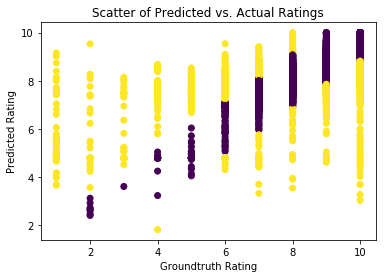

In [205]:
plt.xlabel('Groundtruth Rating')
plt.ylabel('Predicted Rating')
plt.title('Scatter of Predicted vs. Actual Ratings')
plt.scatter(prediction_df["rui"], prediction_df["est"], c=prediction_df["Err_Class"])

In [206]:
!ls

2.22 Work.ipynb            bigger_data.csv
Nintendo                   data.csv
Nintendo_Experiments.ipynb games_meta_new.csv
Nintendo_Learning.ipynb    new_data.csv


In [235]:
game_meta = pd.read_csv("games_meta_new.csv")
game_meta.head()

,developer,game_title,genre,platform,price,publisher,release_date
0,Sunsoft,Daedalian Opus (GB),['Puzzle'],Game Boy,NaN,Vic Tokai,20th Jul 1990
1,Electronic Arts,The Sims 2: Pets (DS),['Creative'],DS,NaN,EA Redwood Shores,27th Oct 2006
2,SEGA,Samba De Amigo (Wii),['Creative'],Wii,NaN,Gearbox Software,23rd Sep 2008
3,Nintendo,Nintendo Badge Arcade (3DS eShop),['Other'],3DS eShop,Free To Start,Nintendo,12th Nov 2015
4,Nicalis,NightSky (3DS eShop),['Puzzle'],3DS eShop,$9.99,Nifflas,25th Oct 2012


In [231]:
df

,User,Game,Rating,item_id
0,dumedum,The Legend of Zelda: Breath of the Wild,10,3780
1,dumedum,Tom Clancy's Ghost Recon: Shadow Wars 3D,10,3937
2,dumedum,Darkman,10,818
3,Action51,Pokémon Sun and Moon,9,2774
4,Action51,Twisted Fusion,7,4017
5,Action51,Star Fox Zero,7,3389
6,Action51,Fire Emblem Fates,7,1256
7,Action51,Xenoblade Chronicles X,8,4233
8,Action51,Super Mario Maker,9,3516
9,Action51,Code Name: S.T.E.A.M.,9,705


In [236]:
#Need to strip out the platform from the metadata file

new_game = game_meta["game_title"].str.split("\s+\(", n=1, expand=True)
game_meta["Game"] = new_game[0]
game_meta.head()

,developer,game_title,genre,platform,price,publisher,release_date,Game
0,Sunsoft,Daedalian Opus (GB),['Puzzle'],Game Boy,NaN,Vic Tokai,20th Jul 1990,Daedalian Opus
1,Electronic Arts,The Sims 2: Pets (DS),['Creative'],DS,NaN,EA Redwood Shores,27th Oct 2006,The Sims 2: Pets
2,SEGA,Samba De Amigo (Wii),['Creative'],Wii,NaN,Gearbox Software,23rd Sep 2008,Samba De Amigo
3,Nintendo,Nintendo Badge Arcade (3DS eShop),['Other'],3DS eShop,Free To Start,Nintendo,12th Nov 2015,Nintendo Badge Arcade
4,Nicalis,NightSky (3DS eShop),['Puzzle'],3DS eShop,$9.99,Nifflas,25th Oct 2012,NightSky


In [237]:
game_meta = game_meta.drop_duplicates(subset="Game", keep='first')

In [238]:
game_meta.head()

,developer,game_title,genre,platform,price,publisher,release_date,Game
0,Sunsoft,Daedalian Opus (GB),['Puzzle'],Game Boy,NaN,Vic Tokai,20th Jul 1990,Daedalian Opus
1,Electronic Arts,The Sims 2: Pets (DS),['Creative'],DS,NaN,EA Redwood Shores,27th Oct 2006,The Sims 2: Pets
2,SEGA,Samba De Amigo (Wii),['Creative'],Wii,NaN,Gearbox Software,23rd Sep 2008,Samba De Amigo
3,Nintendo,Nintendo Badge Arcade (3DS eShop),['Other'],3DS eShop,Free To Start,Nintendo,12th Nov 2015,Nintendo Badge Arcade
4,Nicalis,NightSky (3DS eShop),['Puzzle'],3DS eShop,$9.99,Nifflas,25th Oct 2012,NightSky


In [239]:
df_2 = pd.merge(df,game_meta[['Game','genre']],on='Game', how='left')

In [241]:
df_2.head()

,User,Game,Rating,item_id,genre
0,dumedum,The Legend of Zelda: Breath of the Wild,10,3780,"['Action', 'Adventure']"
1,dumedum,Tom Clancy's Ghost Recon: Shadow Wars 3D,10,3937,"['Action', 'Adventure', 'Strategy']"
2,dumedum,Darkman,10,818,NaN
3,Action51,Pokémon Sun and Moon,9,2774,['RPG']
4,Action51,Twisted Fusion,7,4017,NaN


In [244]:
prediction_df = prediction_df.rename(columns={"iid": "Game"})
prediction_df.head()

,uid,Game,rui,est,details,Iu,Ui,err,Err_Class
0,JoeDiddley,Namco Museum,8.0,8.043908,{'was_impossible': False},156,7,0.043908,0
1,Zuljaras,Metroid Fusion,10.0,9.839272,{'was_impossible': False},34,29,0.160728,0
2,Hawkstream,Mario Kart 8 Deluxe,10.0,8.425044,{'was_impossible': False},6,131,1.574956,1
3,Ghost-Piece,Super Mario Odyssey,1.0,7.039398,{'was_impossible': False},579,133,6.039398,1
4,Ryu_Niiyama,Phoenix Wright: Ace Attorney Trials and Tribul...,9.0,9.562924,{'was_impossible': False},219,16,0.562924,0


In [ ]:
prediction